# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***


## Import Packages

In [100]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import glob
import os
import logging
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#imageio.plugins.ffmpeg.download()


PREV_LEFT_SLOPE = 0
PREV_RIGHT_SLOPE = 0
PREV_LEFT_LANE = [0,0,0]
PREV_RIGHT_LANE = [0,0,0]

def reset_vars():
    global PREV_LEFT_SLOPE 
    global PREV_RIGHT_SLOPE 
    global PREV_LEFT_LANE 
    global PREV_RIGHT_LANE 
    
    PREV_LEFT_SLOPE = 0
    PREV_RIGHT_SLOPE = 0
    PREV_LEFT_LANE = [0,0,0]
    PREV_RIGHT_LANE = [0,0,0]
    
logging.basicConfig(level=logging.INFO)
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)
logger.disabled = True


## Edge Feature Extraction

This method extracts the lane edges from a given image. The following steps used to do this:
1. Grayscale conversion
2. Apply CLAHE filter to improve contrast and refine edge boundaries
3. Gausian blur to reduce detail 
4. Added a sobel x filter to reduce horizontal noise
4. Call Canny edge detection
5. If not enough edges, dialate to make them continuous
6. If too many edges impose higher canny threshold

In [69]:
def pre_process_canny(image, debug = False):

    # PARAMETERS
    imshape = image.shape
    kernel_size = 7
    sigma_x = 5
    sigma_y = 30
    low_canny_threshold = 25
    high_canny_threshold = low_canny_threshold * 3
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray2 = clahe.apply(gray)
    smooth = cv2.GaussianBlur(gray2, (kernel_size, kernel_size), sigma_x, sigma_y)
    
    sobelx64f = cv2.Sobel(smooth,cv2.CV_64F,1,0,ksize=5)
    abs_sobel64f = np.absolute(sobelx64f)
    sobel_8u = np.uint8(abs_sobel64f)
    
    canny_edges = cv2.Canny(sobel_8u, low_canny_threshold, high_canny_threshold)
    
    #kernel = np.ones((3,3), np.uint8)
    #edges = cv2.dilate(canny_edges, kernel, iterations=1) 
    edges  = canny_edges
    num_edge_pixels = len(np.nonzero(canny_edges)[0])
    logger.debug('number of edge pixels',num_edge_pixels)
    if  num_edge_pixels> 30000:
        edges = cv2.Canny(smooth, 75, 180, apertureSize=3)
        
    if debug == True:
        f, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, figsize=(12, 18))
        ax1.imshow(gray, cmap = 'Greys_r')
        ax1.set_title('grayscale', fontsize = 12)
        ax2.imshow(gray2, cmap = 'Greys_r')
        ax2.set_title('CLAHE', fontsize = 12)
        ax3.imshow(smooth, cmap = 'Greys_r')
        ax3.set_title('Gausian Blur', fontsize=12)
        ax4.imshow(edges, cmap = 'Greys_r')
        ax4.set_title('Edges', fontsize=12)    
    
    plt.show()
    
    return edges

def test_pre_process_canny(test_img_path):
    #test_img_path = '/Users/enterprise/Dev/Git/CarND-LaneLines-P1/test_images/solidWhiteCurve.jpg'
    img = cv2.imread(test_img_path)
    if img is None:
        logger.info("Failed to load", fn)
    edges = pre_process_canny(img, True)

--- 
## Color Feature Extraction
This is used to extract the lane edges based on the color information. The following steps are used to acheive this:

1. Convert BGR to HSV
2. Threshold the HSV image to get only yellow colors
3. Threshold the RBG image to get only white colors
4. Or the thresholded images to create a mask
5. Bitwise-AND mask and original image
6. Erode to reduce selected pixels

In [41]:
def colorfilter(frame): 
    
    image = np.copy(frame)
    param_1 = 68
    param_2 = 60
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    hsl = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS)

    yellow_1 = cv2.inRange(hsv, np.array([90, 50, 50]), np.array([100, 255, 255]))
    yellow_2 = cv2.inRange(hsv, np.array([20, 100, 100]), np.array([50, 255, 255]))
    white_1 = cv2.inRange(image, np.array([200,200,200]), np.array([255,255,255]))
    white_2 = cv2.inRange(hsv, np.array([0,0,255-param_1]), np.array([255,20,255]))
    white_3 = cv2.inRange(hsl, np.array([0,255-param_2,0]), np.array([255,255,param_2]))
    
    mask = yellow_1 | yellow_2 |white_1 |white_2 |white_3
    
    
    res = cv2.bitwise_and(frame,frame, mask= mask)
    
    #kernel = np.ones((5,5), np.uint8)
    #img = cv2.erode(res, kernel, iterations=1)
    
    return(res[:,:,2])

def test_colorfilter(test_img_path):
    #test_img_path = '/Users/enterprise/Dev/Git/CarND-LaneLines-P1/test_images/solidWhiteCurve.jpg'
    img = cv2.imread(test_img_path)
    if img is None:
        logger.info("Failed to load", fn)
    result = colorfilter(img)
    plt.imshow(result, cmap = 'Greys_r')
    plt.show()  

---
## Region of Interest Mask
 Applies an image mask.
Only keeps the region of the image defined by the polygon
formed from `vertices`. The rest of the image is set to black.
1. vertice set 1, vertices set 1 for the birds eye view
2. defining a blank mask to start with
3. defining a 3 channel or 1 channel color to fill the mask with depending on the input image
4. filling pixels inside the polygon defined by vertices with the fill color    
5. returning the image only where mask pixels are nonzero

In [132]:
def roi_mask(image):
    imshape = image.shape

    #vertices set 1
    y_max = imshape[0]-10
    y_min = 12*imshape[0]/18 # changing from 10
    x_min = imshape[1]/20
    x_1 = 7*imshape[1]/20 # change from 9
    x_2 = 13*imshape[1]/20 # change from 11
    x_max = 19*imshape[1]/20
    
    #

    '''
    #vertices set 2
    y_max = imshape[0]-70
    y_min = imshape[0]/10
    x_min = 0 + 80
    x_1 = 5*imshape[1]/20
    x_2 = 15*imshape[1]/20
    x_max = imshape[1] - 80
    '''

    vertices = np.array([[(x_min,y_max), (x_1, y_min), (x_2, y_min),(x_max,y_max)]], dtype=np.int32)
    mask = np.zeros_like(image)   

    if len(imshape) > 2:
        channel_count = imshape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, [vertices], ignore_mask_color)

    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def test_roi_mask(test_img_path):
    #test_img_path = '/Users/enterprise/Dev/Git/CarND-LaneLines-P1/test_images/solidWhiteCurve.jpg'
    img = cv2.imread(test_img_path)
    if img is None:
        logger.info("Failed to load", fn)
    result = roi_mask(img)
    plt.imshow(result)
    plt.show()


## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [43]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

---
## Feature Detection

The edge and color features extracted in the previous steps are used in this step. Lines present in the given image are detected through the probablistic Hough Transform. The detected line segments are classified as  part of left lane or right lane based on a set of heuristic conditions. 

for each set of classified line segments, a representative line is created using the average slope and X intercept. 

Finally, the weighted average method is used to create a first order filter and tom ensure that the detected lines dont move abrupbtuly from one frame to the other. 


In [134]:
def line_detect(roi_frm):
    ret = 1
    h,w = roi_frm.shape   # height and width in pixels

    rho = 1             # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180 # angular resolution in radians of the Hough grid
    hough_threshold = 30      # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
    line_image = np.zeros((h,w,3), np.uint8)
    #line_image = np.copy(roi_frm)*0 # creating a blank to draw lines on

    # Run Probabilistic Hough Transform to extract line segments from Binary image.
    lines = cv2.HoughLinesP(roi_frm,rho,theta,hough_threshold,min_line_length,max_line_gap)

    
    #Variable decleration
    
    y_max = int(h - 10)
    y_min = int(11 * h / 18)
    
    logger.debug('y_max=',y_max,'y_min=',y_min)

    global PREV_LEFT_SLOPE, PREV_RIGHT_SLOPE, PREV_LEFT_POINTS, PREV_RIGHT_POINTS
    prev_weight = 0.9

    r_Y_arr = []
    r_X_arr = []
    r_Slope_arr = []
    r_intercept = []

    l_Y_arr = []
    l_X_arr = []
    l_Slope_arr = []
    l_intercept = []


    logger.info(' processing ...')
    # Loop for every single line detected by Hough Transform
    
    #exception in no lines are found
    if lines is None: 
        r_Slope_arr.append(PREV_RIGHT_SLOPE)
        r_X_arr.append(PREV_RIGHT_POINTS[0])
        r_X_arr.append(PREV_RIGHT_POINTS[2])
        r_Y_arr.append(PREV_RIGHT_POINTS[1])
        r_Y_arr.append(y_max)
        r_intercept.append(PREV_RIGHT_POINTS[2])
        
        l_Slope_arr.append(PREV_LEFT_SLOPE)
        l_X_arr.append(PREV_LEFT_POINTS[0])
        l_X_arr.append(PREV_LEFT_POINTS[2])
        l_Y_arr.append(PREV_LEFT_POINTS[1])
        l_Y_arr.append(y_max)
        l_intercept.append(PREV_LEFT_POINTS[2])
        
    else:
        #print('%d lines detect ...' % lines.shape[0])
        for line in lines:
            for x1,y1,x2,y2 in line:
                dx = x2 - x1 + 0.0001
                dy = y2 - y1
                #slope, yint = np.polyfit((x1, x2), (y1, y2), 1)
                slope = dy / dx
                theta = np.abs(np.arctan2((y2-y1), (x2-x1)))
                angle = theta * (180/np.pi)
                #cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
                #logger.debug(x1, y1, x2, y2, angle, slope)
                if abs(angle)>10:         #for removing horizontal lines
                    # Right lane marking -> positive slope and in right half of the frame
                    #print(x1, y1, x2, y2, angle, slope)
                    if x1 > 0.4*w and x2 > 0.4*w and slope > 0:
                        r_Y_arr.extend([y1,y2])
                        r_X_arr.extend([x1,x2])
                        #r_XY_arr = np.append(r_XY_arr,[[x1,x2],[y1,y2]],1)
                        r_Slope_arr.append(slope)
                        if angle>89.9:
                            x_int = x1
                        else:
                            x_int =  int(x1 + (-y_max + y1) / - slope)
                        r_intercept.append(x_int)
                        #print('right',x1,y1,x2,y2,slope,angle,x_int) 
                        #cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
                    # left lane marking -> negative slope and in left half of the frame
                    elif x1 < 0.6*w and x2 < 0.6*w and slope < 0:
                        l_Y_arr.extend([y1,y2])
                        l_X_arr.extend([x1,x2])
                        #l_XY_arr = np.append(l_XY_arr,[[x1,x2],[y1,y2]],1)
                        l_Slope_arr.append(slope)
                        if angle>89.9:
                            x_int = x1
                        else:
                            x_int =  int(x1 + (-y_max + y1) / - slope)
                        l_intercept.append(x_int)
                        #print('left',x1,y1,x2,y2,slope,angle,x_int)
                        #cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)

    data_lanes = np.array((l_Slope_arr,r_Slope_arr,l_Y_arr,l_X_arr,r_Y_arr,r_X_arr))

    # Right Lane
    if r_Y_arr:
        r_x2 = np.average(r_intercept)
        r_slope = np.average(r_Slope_arr)
        
        # Update slope 
        if PREV_RIGHT_SLOPE !=0:
            r_slope = r_slope + (PREV_RIGHT_SLOPE - r_slope) * prev_weight

        #print('R_slope=',r_slope)
        #print('r_x2=',r_x2)
        
        r_x2 = int(r_x2)
        r_y2 = int(y_max)
        r_y1 = int(y_min)
        r_x1 = int(r_x2 + (-r_y2 + r_y1)/ r_slope)
    
        # Update rest of the cordinates
        if PREV_RIGHT_SLOPE !=0:
            r_x1 = int(r_x1 + (PREV_RIGHT_POINTS[0] - r_x1) * prev_weight)
            r_y1 = int(r_y1 + (PREV_RIGHT_POINTS[1] - r_y1) * prev_weight)
            r_x2 = int(r_x2 + (PREV_RIGHT_POINTS[2] - r_x2) * prev_weight)

        PREV_RIGHT_SLOPE = r_slope
        PREV_RIGHT_POINTS = [r_x1, r_y1, r_x2]
        #print('Right',r_x1, r_y1, r_x2, y_max,r_slope)
        cv2.line(line_image, (r_x1, r_y1), (r_x2, r_y2), (255,0,0), 10)
    else:
        print('No Right Lane!!!')
        ret = 0


    # Left Lane
    if l_Y_arr:
        l_x2 = np.average(l_intercept)
        l_slope = np.average(l_Slope_arr)
        
        if PREV_LEFT_SLOPE !=0:
            l_slope = l_slope + (PREV_LEFT_SLOPE - l_slope) * prev_weight

        l_x2 = int(l_x2)
        l_y2 = y_max
        l_y1 = y_min
        l_x1 = int(l_x2 + (-l_y2 + l_y1) /l_slope)
        
        #print('l_slope=',l_slope)
        #print('l_x2=',l_x2)

        if PREV_LEFT_SLOPE !=0:
            l_x1 = int(l_x1 + (PREV_LEFT_POINTS[0] - l_x1) * prev_weight)
            l_y1 = int(l_y1 + (PREV_LEFT_POINTS[1] - l_y1) * prev_weight)
            l_x2 = int(l_x2 + (PREV_LEFT_POINTS[2] - l_x2) * prev_weight)

        PREV_LEFT_SLOPE = l_slope
        PREV_LEFT_POINTS = [l_x1, l_y1, l_x2]
        #print('Left' ,l_x1, l_y1, l_x2, y_max,l_slope)
        cv2.line(line_image, (l_x1, l_y1), (l_x2, l_y2), (255,0,0), 10)
    else:
        print('No Left Lane !!!')
        ret = 0
    
    return(ret,line_image)
    

---
## Processing Pipeline

The pipeline method recieves the image and the imtrinsic camera parameters and provides annotated image with lane markers identified. This pipeline can be used to process images or frames from a video. The following steps are impemented in this method:
1. Recieve image
2. Edge and color based feature extraction
3. Line detection and lane marking
4. Transform the line markings from a birds eye view to perspective projection
5. Combine line markings to the recieved image 

**pipeline**(image,test_im = True,debug = False):
 - image : Input image
 - test_im = True: For video input, set to False to apply moving average lane tracking
 - debug = False: Set to True to disply various stages of the pipeline 

In [106]:
def pipeline(image,test_im = True,debug = False):
    logger.info('Pipeline initiated ...')
    if test_im:
        reset_vars()
    
    frame = np.copy(image)
    img_size = frame.shape

    canny_edges = pre_process_canny(frame)
    logger.info('Canny edges',canny_edges.shape)
    lane_pixels = colorfilter(frame)
    logger.info('Thresholding edges',lane_pixels.shape)
    hough_input = roi_mask(canny_edges + lane_pixels)
    
    ret, line_image = line_detect(hough_input)
    #print(line_image.shape, line_image.dtype)
    
    #combo_2 = cv2.addWeighted(dist_view_1, 0.95, corrected_img, 1, 0)
    #combo_2 = cv2.add(corrected_img,dist_view_1)
    combo_2 = weighted_img(line_image, frame, α=0.8, β=1., λ=0.)
    
    logger.info('... Pipeline complete!')
    
    if debug:
        print('output at different states of the pipeline')
        f, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(6, 1, figsize=(12, 18))
        ax1.imshow(frame)
        ax1.set_title('original image', fontsize = 12)
        ax2.imshow(hough_input, cmap = 'Greys_r')
        ax2.set_title('Hough Input', fontsize = 12)
        ax3.imshow(canny_edges, cmap = 'Greys_r')
        ax3.set_title('Canny Edges', fontsize=12)
        ax4.imshow(lane_pixels, cmap = 'Greys_r')
        ax4.set_title('Color Edges', fontsize=12)
        ax5.imshow(line_image, cmap = 'Greys_r')
        ax5.set_title('Hough line', fontsize=12)
        ax6.imshow(combo_2)
        ax6.set_title('Annotated image', fontsize=12)

        plt.show()
    
    return(combo_2)
    

In [116]:
def test_pipeline():
    test_img_path = '/Users/enterprise/Dev/Git/CarND-LaneLines-P1/test_images/solidYellowCurve.jpg'
    
    img = mpimg.imread(test_img_path)
    logger.info('Processing... '+test_img_path)
    if img is None:
        logger.debug("Failed to load", fn)

    result = pipeline(img,True, True)
    logger.info('OK')

---
## Test Methods
### Testing the given image set

**test_images**(test_images_path, save = False, plot = True):
 - test_image_path: Directory path containing the images
 - output_image_path: Directory path to save the output images
 - save: Boolean. True to save output images to the specified outptu directory
 - plot: Boolean. True to plot the results


In [96]:
# Test Images
def test_images(test_images_path,output_image_path, save = False, plot = True):

    # create image list    
    for ind, fn in enumerate(test_images_path):
        print('processing %s... ' % fn, end='')
        img = mpimg.imread(fn)
        if img is None:
            print("Failed to load", fn)
            continue
        result = pipeline(img,True,False)
        print('ok',ind)
        if save:
            #plt.imshow(result)
            infile = os.path.basename(fn)
            outfile = (output_image_path+infile+'_output.png')
            cv2.imwrite(outfile,result)
        
    
        if plot:
            fig, ((axs1, axs2)) = plt.subplots(1,2, figsize=(12, 18), facecolor='w', edgecolor='k')
            axs1.imshow(img)
            axs1.set_title('Input:'+fn, fontsize = 12)
            axs2.imshow(result)
            axs2.set_title('Output:'+outfile, fontsize = 12)
            plt.show()
        
        result = None
    return

### Testing the given Video set

**test_videos**(video_file, output_video_path):
 - video_file: Video file path
 - output_video_path: Output path for the video
 
 Information regarding Codecs and video extension courtesy: [http://www.pyimagesearch.com/2016/02/22/writing-to-video-with-opencv/]

In [145]:
def test_videos(video_file, output_video_path):
    
    cap = cv2.VideoCapture(video_file)
    print("Processing... "+video_file,end='')
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = cap.get(7)
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    writer = None
    (h,w) = (None, None)
    zeros = None
    
    infile = os.path.basename(video_file)
    outfile = (output_video_path+infile+'_output.avi')
    cnt = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            cnt+= 1
            if writer is None:
                (h,w) = frame.shape[:2]
                writer = cv2.VideoWriter(outfile,fourcc, fps, (w,h),True)
                prog = int(cnt/total_frames * 100)
                if prog % 10 == 0:
                    print(prog, "percent complete ...")
            result = pipeline(frame,test_im = False)
            writer.write(result)
            
        else:
            break
    print('Done!')
    # Release everything if job is finished
    cap.release()
    writer.release()
    return()

In [147]:
def main():
    
    cal_images_path = 'camera_cal'
    test_images_path = glob.glob('test_images/*.jpg')
    test_videos_path = glob.glob('./*.mp4')
    output_image_path = 'output_images/'
    output_video_path = '/Users/enterprise/Desktop/resources/output_videos/'
    #output_video_path = 'output_videos/'
    
    #test_camera_cal()
    #test_pre_process_canny(test_img_path)
    #test_colorfilter(test_img_path)
    #test_roi_mask()
    
    #test_pipeline()
    #test_images(test_images_path,output_image_path,True,True)
    test_videos(test_videos_path[2],output_video_path)
    
    
if __name__ == "__main__":
    main()

Processing... ./raw-lines-example.mp40 percent complete ...
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Right Lane!!!
No Ri

KeyboardInterrupt: 

(540, 960, 3)


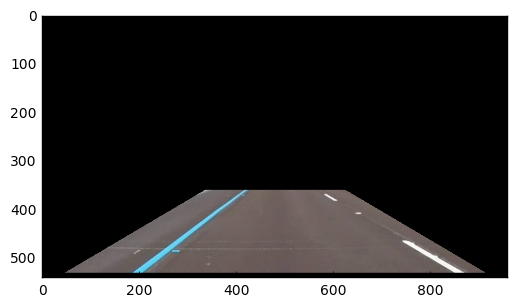

output at different states of the pipeline


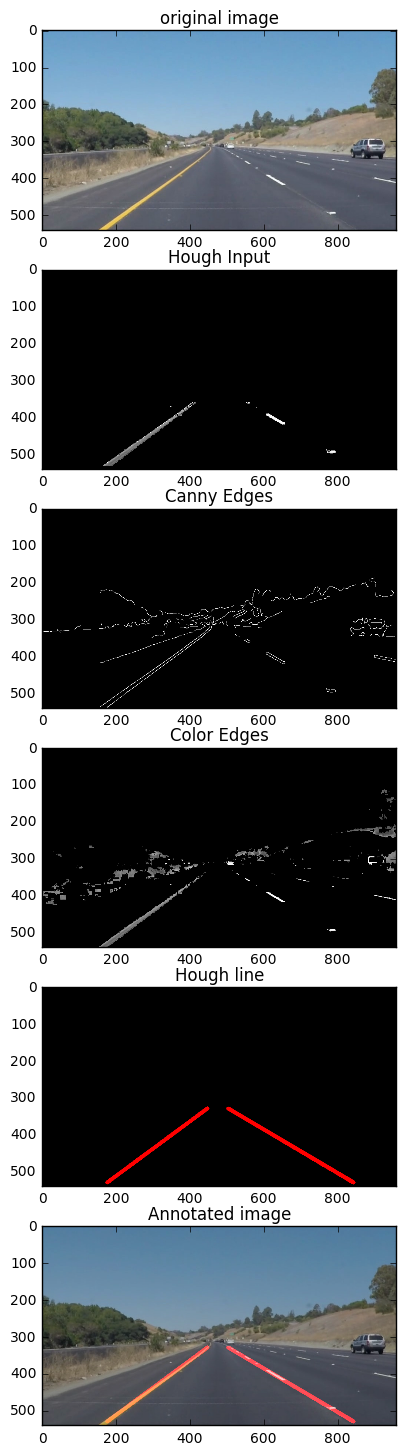

In [135]:
test_img_path = '/Users/enterprise/Dev/Git/CarND-LaneLines-P1/test_images/whiteCarLaneSwitch.jpg'
orig_img = mpimg.imread(test_img_path)
if orig_img is None:
        logger.debug("Failed to load")
print(orig_img.shape)
#test_pre_process_canny(test_img_path)
#test_colorfilter(test_img_path)
test_roi_mask(test_img_path)

test_pipeline()

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))